# Feature Evaluation
We will now evaluate how each model evaluates features by randomly shuffling a single column in turn and seeing how this impacts the binary accuracy score. Features of greater importance should effect this score to a larger degree. Thus feature importance is proportional to the magnitude of the change in the performance metric.

In [23]:
import pandas as pd
from joblib import load
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [24]:
version = '9.0.5'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = df = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

# Initial Accuracies

In [25]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')
xgb = load(f'../classification_methods/models/XGB_{version}.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn, 'XGB': xgb}

/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might

In [68]:
cols_to_shuffle = X_train.columns.to_list()

In [76]:
orig_accs = []
for name, model in models.items():
    try:
        preds = model.predict_proba(X_train.to_numpy())[:,1]
    except:
        preds = model.predict(X_train.to_numpy()).flatten()
    pred_class = np.where(preds>0.5, 1, 0).flatten()
    orig_acc = accuracy_score(y_train, pred_class)
    orig_accs.append(orig_acc)
    print(f"Accuracy: {orig_acc:.5f}")

Accuracy: 0.95140
Accuracy: 0.94146
Accuracy: 0.95360
Accuracy: 0.92442
Accuracy: 0.95140
Accuracy: 0.96276


# Randomly Shuffle

In [70]:
all_new_accs = []

for name, model in models.items():
    new_accs = []
    for col in cols_to_shuffle:
        dummy = X_train.copy()
        # Do this each time to ensure the old changes aren't permuted across
        dummy[col] = np.random.permutation(X_train[col])

        try:
            preds = model.predict_proba(dummy.to_numpy())[:,1]
        except:
            preds = model.predict(dummy.to_numpy()).flatten()

        pred_class = np.where(preds>0.5, 1, 0).flatten()
        new_acc = accuracy_score(y_train, pred_class)
        new_accs.append(new_acc)
    all_new_accs.append(new_accs)

# Plot Results

In [82]:
a = pd.DataFrame({'Feature': cols_to_shuffle})
for i, accs in enumerate(all_new_accs):
    change_in_acc = orig_accs[i] - np.array(accs)
    # The importance of the feauture is proportional to the change in accuracy 
    importance = change_in_acc * (1/np.max(change_in_acc))
    importance /= np.sum(importance)
    a[list(models.keys())[i]] = importance

a = a.sort_values('OLDNN', ascending=False)
a.to_csv('permutation_importance.csv', index=False, header=True)

# Visualise Results

In [83]:
df = pd.read_csv('permutation_importance.csv')
df.head()

,Feature,NN,KNN,RFC,DTC,OLDNN,XGB
0,LN_Lb_DTF_PV_chi2,0.163128,0.194603,0.315629,0.204752,0.154668,0.368444
1,JPs_ORIVX_CHI2,0.121248,0.023985,0.010699,0.202722,0.139450,0.000000
2,LN_Lb_IP_OWNPV,0.112462,0.050968,0.044708,0.001074,0.106234,0.015269
3,LN_Lb_IP23,0.109826,0.100300,0.060374,0.019222,0.106087,0.082762
4,Lb_PT,0.075707,0.097847,0.048147,0.000000,0.077553,0.011507


In [87]:
df['avg'] = np.mean(df[['NN', 'KNN', 'RFC', 'DTC', 'OLDNN', 'XGB']], axis=1)

In [89]:
df = df.sort_values('avg', ascending=False)

In [90]:
df.head()

,Feature,NN,KNN,RFC,DTC,OLDNN,XGB,avg
0,LN_Lb_DTF_PV_chi2,0.163128,0.194603,0.315629,0.204752,0.154668,0.368444,0.233537
1,JPs_ORIVX_CHI2,0.121248,0.023985,0.010699,0.202722,0.139450,0.000000,0.083017
3,LN_Lb_IP23,0.109826,0.100300,0.060374,0.019222,0.106087,0.082762,0.079762
6,LStar_IP_ORIVX,0.060624,0.017443,0.066106,0.065425,0.063360,0.079221,0.058697
2,LN_Lb_IP_OWNPV,0.112462,0.050968,0.044708,0.001074,0.106234,0.015269,0.055119


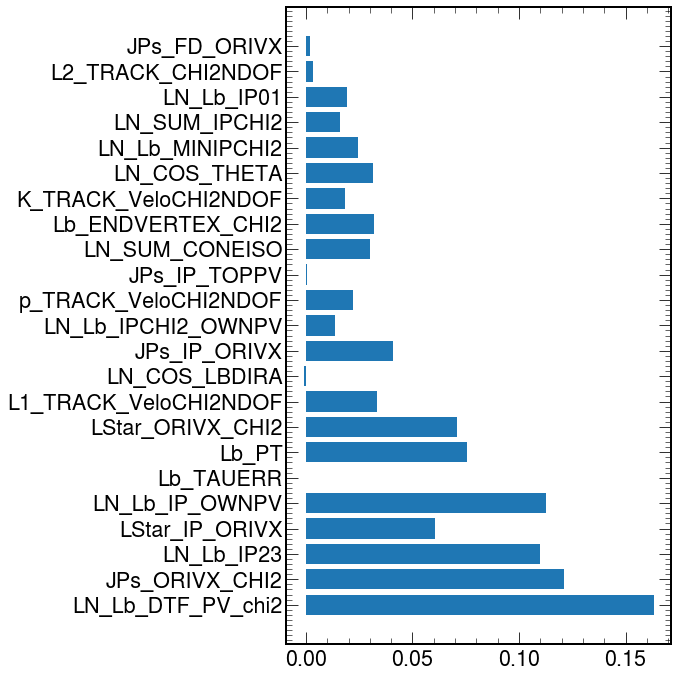

In [121]:
X = np.arange(len(df['Feature']))
name = 'NN'
fig, ax = plt.subplots(1, 1)
ax.barh(X, df[name], align='center')
ax.set_yticks(X, labels=df['Feature'])
plt.tight_layout()
plt.savefig(f'../images/ModelEval/{name}_Permutation_Importance.png')
plt.show()